<a href="https://colab.research.google.com/github/andreyzer/PicoR-GPR-report-preparation/blob/master/picor_guide_3_road_rus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Руководство по формированию отчета на базе записей георадара Пикор при работе по дорожному покрытию

Работа с вашими записями будет проводится в данном файле. Поэтому чтобы сохранить исходный файл руководства, перед началом работы сохраните этот файл под нужным названием. Для этого нажмите File -> Make a copy. Затем в скопированном файле File -> Rename и введите нужное название 

В данном руководстве работаем со следующими текстовыми файлами:

- файл с корректными границами толщины слоя дорожного покрытия (с расширением del). Это может быть файл, который формируется автоматически, без серьезных ошибок или файл с откорректированными вручную границами. Если в файле имеются сбои алгоритма, перескоки границ и т.п., эти ошибки будут и в итоговой таблице, и на графике. Например, файл: _19_ 08.11.2018 13_02_30_sav_layer_1.del
- файл с координатами (с расширением gps). Например, файл: _19_ 08.11.2018 13_02_30.gps
- файл с метками (с расширением lab). Например, файл: _19_ 08.11.2018 13_02_30.lab

Если какого-то из них нет, воспользуйтесь другими соответствующими руководствами

In [1]:
# верхние 3 ячейки - текстовые, эта - первая ячейка с кодом. В нее не нужно вносить изменения, но ее нужно выполнить
# для этого нажать левой кнопкой мыши в любое место ячейки и нажать Run в меню. Тогда активной станет следующая ячейка

# если не нужно исполнение любой строки или целой ячейки, поставьте решетку перед каждой строкой (т.е. закомментируйте)

# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import folium  
from folium import features
import altair as alt

import warnings
warnings.filterwarnings("ignore")

# максимальное выводимое число строк таблицы 500 (можно менять при необходимости)
pd.options.display.max_rows = 500

sns.set(style="whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# при 1-м запуске установите библиотеку geopandas, далее установите решетку перед командой (знаком !)
#!pip install geopandas

     |████████████████████████████████| 931kB 9.6MB/s 
     |████████████████████████████████| 14.7MB 274kB/s 
     |████████████████████████████████| 10.9MB 50.3MB/s 


Аномальные значения в 99% от значений толщины: 20 см и выше 

Первые 5 строк таблицы толщины слоя:


,frame_number,first_limit_ns,second_limit_ns,layer_thickness
0,1,1.30,0.11,8
1,2,1.88,3.63,12
2,3,1.88,3.63,12
3,4,1.88,3.63,12
4,5,1.88,3.63,12


Последние 5 строк таблицы толщины слоя:


,frame_number,first_limit_ns,second_limit_ns,layer_thickness
8350,9996,2.44,4.33,13
8351,9997,2.44,4.33,13
8352,9998,2.44,4.33,13
8353,9999,2.44,4.33,13
8354,10000,2.44,4.33,13


Всего точек измерений толщины слоя: 8355 



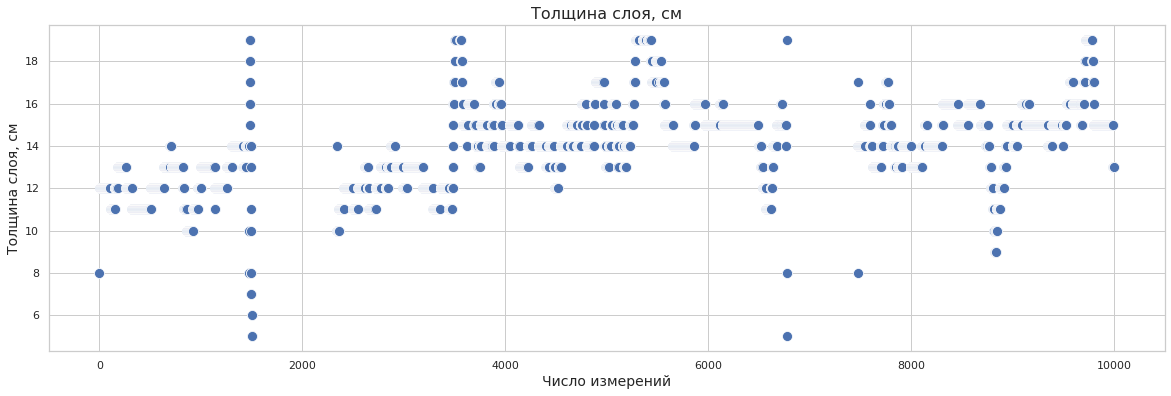

In [3]:
# здесь и во всех кодовых ячейках ниже можно вносить изменения и выполнять ячейки, нажав Run

# загружаем файл с границами толщины слоя. Копируем его название вместе с расширением и вставляем ниже между кавычками
layer_thickness = pd.read_csv('_19_ 08.11.2018 13_02_30_sav_layer_1.del', sep=' ', decimal=',', header=0)

# тут ничего не меняем
layer_thickness = layer_thickness[['Номер', 'кадра:', 'Первая']]
layer_thickness.columns = ['frame_number', 'first_limit_ns', 'second_limit_ns']

# формула расчета толщины слоя из разницы во времени отражения сигнала от двух границ
layer_thickness['layer_thickness'] = abs(((layer_thickness['second_limit_ns']-layer_thickness['first_limit_ns'])\
                                           *15*0.49).astype(int)) # для асфальта

# определим аномальные значения в 99% от значений толщины. Если не нужно, поставьте # перед началом строки
outlier = layer_thickness['layer_thickness'].quantile(.99)
print('Аномальные значения в 99% от значений толщины:', int(outlier), 'см и выше', '\n')

# удалим части таблиц, где толщина слоя менее 5 см (места остановки автомобиля) и больше аномальных значений
# если не нужно, поставьте # перед началом строки
layer_thickness = layer_thickness.query('5 <= layer_thickness < @outlier').reset_index(drop=True)

# делаем реиндексацию frame_number после удаления строк с места остановок
#layer_thickness['frame_number'] = layer_thickness.index

# можно вывести любое число строк таблицы, нужно указать его в скобках после head или tail
print('Первые 5 строк таблицы толщины слоя:')
display(layer_thickness.head(5))
print('Последние 5 строк таблицы толщины слоя:')
display(layer_thickness.tail(5))
print('Всего точек измерений толщины слоя:', len(layer_thickness), '\n')

# построим график, где показаны значения толщины слоя во всех точках измерения
f, ax = plt.subplots(figsize = (20,6))
sns.scatterplot(x = "frame_number", y = "layer_thickness", data = layer_thickness, s=100)
plt.title("Толщина слоя, см", fontsize = 16) 
plt.xlabel("Число измерений", fontsize = 14) 
plt.ylabel("Толщина слоя, см", fontsize = 14) 
#plt.ylim(0, 30) # если нужно настроить диапазон по оси y, удалите значок решетки в начале строки и введите нужные значения
plt.show()

#### Выводы

- загрузили файл с границами толщины слоя
- расчитали толщину слоя из разницы во времени отражения сигнала от двух границ. Она зависит от коэффициента k=(Диэлектрическая проницаемость)(-0.5) (т.е. в степени -1/2). Справочное значение k для асфальта = 0.49. При калибровке прибора (при сравнении толщины слоя, определяемой прибором, и из взятого керна) коэффициент можно корректировать, чтобы значения, полученные обоими методами совпали
- определили аномальные значения в 99% от значений толщины слоя. Это скорее всего ошибки определения границ
- на записи были места остановок автомобиля. При коррекции границ толщины в данных местах были вручную сведены близко друг к другу (стали менее 5 см). Удаляем строки таблицы в данных местах
- вывели первые и последние строки таблицы с определенной толщиной слоя и количество точек измерений толщины слоя после удаления мест остановок автомобиля
- построили график, где показаны значения толщины слоя во всех точках измерения. На нем наглядно видны наиболее частые значения толщины слоя, минимальные и максимальные значения толщины слоя, в каком месте записи они находятся, места остановки автомобиля (пустые области)

Статистика значений толщины слоя:
count    8355.0
mean       14.0
std         2.0
min         5.0
25%        13.0
50%        14.0
75%        15.0
max        19.0
Name: layer_thickness, dtype: float64 

Наиболее часто встречающееся значение толщины слоя (мода): 15 см
Число встречающихся значений толщины слоя: 15


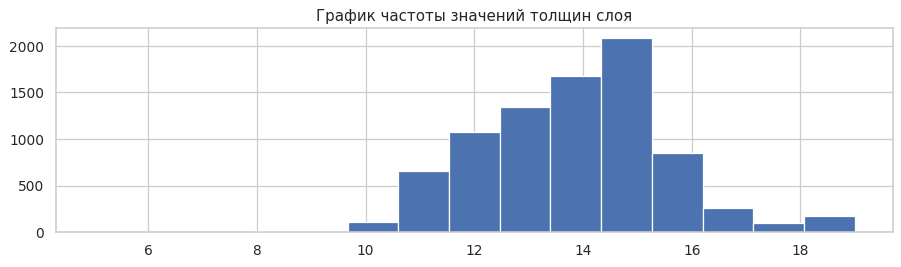

In [4]:
# можно посмотреть статистику по толщине слоя. mean-средняя толщина слоя, min/max-минимальная и максимальная толщина слоя
# 50%-медианное (наиболее частое) значение толщины слоя
print('Статистика значений толщины слоя:')
print(layer_thickness['layer_thickness'].describe().round(0), '\n')
print('Наиболее часто встречающееся значение толщины слоя (мода):', int(layer_thickness['layer_thickness'].mode()),'см')

bins_number = len(layer_thickness['layer_thickness'].value_counts())
print('Число встречающихся значений толщины слоя:', bins_number)

# распределение значений толщин слоя. При необходимости, можно менять число bins (увеличивать, если большая таблица)
plt.figure(figsize=(12,3), dpi= 90)
layer_thickness['layer_thickness'].hist(bins=bins_number)
plt.title('График частоты значений толщин слоя', fontsize=12)
plt.show()   

#### Выводы

- вывели статистику по толщине слоя. Здесь mean - средняя толщина слоя, min/max - минимальная и максимальная толщина слоя, 50%-медианное значение толщины слоя
- определили наиболее часто встречающееся значение толщины слоя (моду)
- определили число встречающихся значений толщины слоя
- вывели график частоты значений толщин слоя. На нем видно, какие толщины встречаются наиболее часто (значение частоты слева по оси y)

Первые 5 строк таблицы координат:


,frame_number,latitude,longitude,latitude_diff,longitude_diff,distance_diff,latitude_diff_sum,longitude_diff_sum,distance
0,17,55.773087,37.518773,0.0,0.0,0.0,0.0,0.0,0.0
1,39,55.773087,37.518773,0.0,0.0,0.0,0.0,0.0,0.0
2,70,55.773087,37.518773,0.0,0.0,0.0,0.0,0.0,0.0
3,87,55.773087,37.518773,0.0,0.0,0.0,0.0,0.0,0.0
4,106,55.773087,37.518773,0.0,0.0,0.0,0.0,0.0,0.0


Последние 5 строк таблицы координат:


,frame_number,latitude,longitude,latitude_diff,longitude_diff,distance_diff,latitude_diff_sum,longitude_diff_sum,distance
377,9860,55.770820,37.516947,0.93,0.66,1.14,-251.76,-145.02,1218.7
378,9878,55.770863,37.516980,4.82,2.64,5.50,-246.94,-142.38,1224.2
379,9902,55.770885,37.517000,2.41,1.59,2.89,-244.53,-140.79,1227.1
380,9953,55.770912,37.517022,2.96,1.72,3.42,-241.57,-139.07,1230.5
381,9978,55.770938,37.517045,2.96,1.85,3.49,-238.61,-137.22,1234.0


Всего точек координат: 382
Среднее расстояние между точками координат: 3.23 м
Среднее расстояние между точками измерения толщины слоя: 15 см
Средняя скорость движения при измерении: 25 км/ч


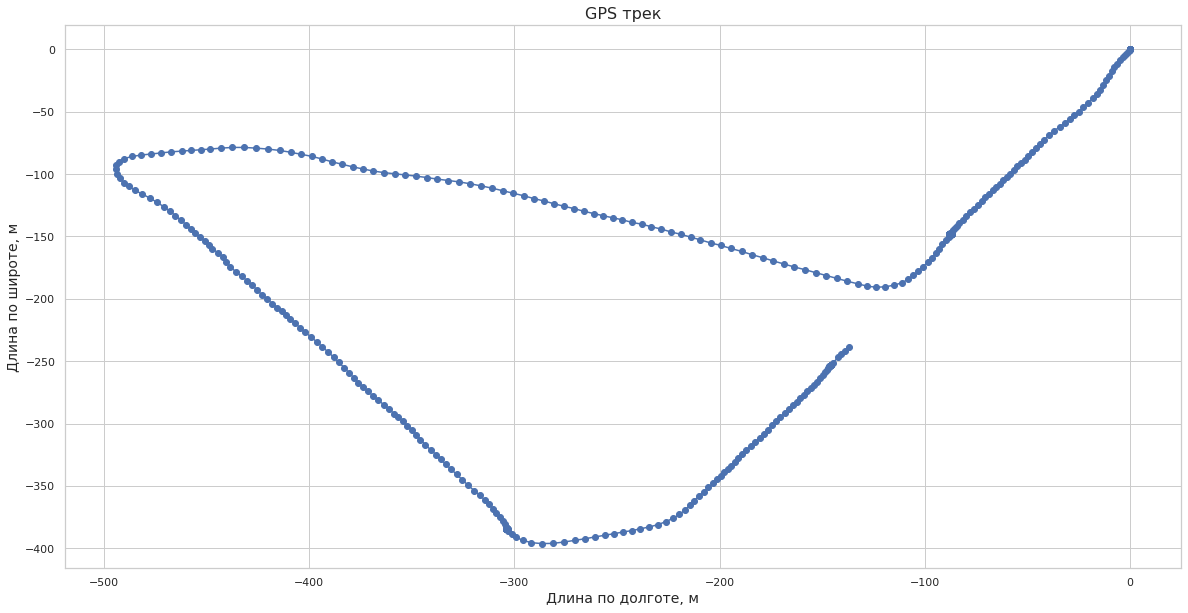

In [5]:
# выгружаем файл с координатами. Копируем его название вместе с расширением и вставляем ниже между кавычками
gps_track = pd.read_csv('_19_ 08.11.2018 13_02_30.gps', sep=' ', decimal=',', header=0, names=['frame_number','longitude',\
                                                                                               'latitude','NaN'])

# тут ничего не меняем
gps_track = gps_track.drop('NaN', axis = 1)
neworder = ['frame_number','latitude','longitude']
gps_track=gps_track.reindex(columns=neworder)

# считаем разницу между точками координат в метрах
gps_track['latitude_diff'] = (gps_track['latitude'].diff() * 111134.861111).round(2)
gps_track['longitude_diff'] = (gps_track['longitude'].diff() * 111321.377778 * math.cos(gps_track['latitude'].mean()))\
.round(2)
gps_track = gps_track.fillna(0)

# считаем длину каждого участка между точками координат
gps_track['distance_diff'] = ((gps_track['latitude_diff']**2 + gps_track['longitude_diff']**2)**(0.5)).round(2)

# считаем общую длину и длины по координатам, суммируя длины по участкам
lengps = len(gps_track)-1
gps_track['latitude_diff_sum'] = gps_track['latitude_diff'].rolling(min_periods=1,window=lengps).sum()
gps_track['longitude_diff_sum'] = gps_track['longitude_diff'].rolling(min_periods=1,window=lengps).sum()
gps_track['distance'] = gps_track['distance_diff'].rolling(min_periods=1,window=lengps).sum().round(1)
gps_track = gps_track.loc[gps_track['frame_number'] != lengps]

print('Первые 5 строк таблицы координат:')
display(gps_track.head(5))
print('Последние 5 строк таблицы координат:')
display(gps_track.tail(5))
print('Всего точек координат:', len(gps_track))

print('Среднее расстояние между точками координат:', (gps_track.tail(1).loc[len(gps_track)-1,'distance'] / len(gps_track))\
      .round(2), 'м')
print('Среднее расстояние между точками измерения толщины слоя:',int((gps_track.tail(1).loc[len(gps_track)-1,'distance'] / \
                                                                  len(layer_thickness)*100).round(0)), 'см')

print('Средняя скорость движения при измерении:',int(gps_track.tail(1).loc[len(gps_track)-1,'distance'] / \
      layer_thickness['frame_number'].max() * 56.8 *3.6), 'км/ч') # здесь 56.8 - частота измерений в секунду

f, ax = plt.subplots(figsize = (20,10))
plt.plot(gps_track.longitude_diff_sum, gps_track.latitude_diff_sum, marker="o")
plt.title("GPS трек", fontsize = 16)
plt.xlabel("Длина по долготе, м", fontsize = 14)
plt.ylabel("Длина по широте, м", fontsize = 14)
plt.show()

#### Выводы

- загрузили файл с координатами
- посчитали расстояние между точками координат в метрах и длину каждого участка между точками координат
- посчитали общую длину и длины по координатам, суммируя длины по участкам
- посчитали среднее расстояние между точками координат
- посчитали среднее расстояние между точками измерения толщины слоя
- посчитали среднюю скорость движения при измерении
- вывели первые и последние строки таблицы координат и количество точек координат
- построили график с GPS треком. Он совпадает с GPS треком на карте из программы Пикор

In [6]:
# выгружаем файл с метками. Копируем его название вместе с расширением и вставляем ниже между кавычками
labels = pd.read_csv('_19_ 08.11.2018 13_02_30.lab', sep='.', header=0, names=['label_number', 'frame_number'])

# выполним ряд манипуляций для приведения таблицы с метками к виду, как они выглядят на записи
# разделяем данные с метками на отдельные таблицы с основными и дополнительными метками
x = labels[labels['label_number'] == "Дополнительные метки:"].index.values.astype(int)[0]
labels1 = labels[0:x]
y = labels.tail(1).index.values.astype(int)[0]
labels2 = labels[x:y+1]

labels1['frame_number'] = labels1['frame_number'].astype(int)
labels1['label_number'] = labels1['label_number'].astype(int)
labels1 = labels1.drop(index=[0]).reset_index(drop=True) # удаляем метку начала записи
labels1 = labels1.loc[labels1['frame_number'] != labels1['frame_number'].max()] # .reset_index(drop=True)
for i in labels1['label_number']: # меняем порядок меток с учетом удаленной метки начала записи
    labels1['label_number'].replace(i, i-1, inplace=True)

labels2 = labels2.dropna()
labels2['label_number_d'] = ""
labels2['label_number_d'] = labels2.label_number.str.ljust(2, 'd')
labels2_d = labels2[['label_number_d','frame_number']]
labels2_d.columns = ['label_number','frame_number']
labels2 = labels2[['label_number','frame_number']]
   
labels = pd.concat([labels1, labels2]).reset_index(drop=True) # таблица с метками, имеющими числовые значения
labels_d = pd.concat([labels1, labels2_d]).reset_index(drop=True) # таблица с метками, где дополнительные указаны как d

layer_thickness_labels_d = layer_thickness.merge(labels_d, on='frame_number')
layer_thickness_labels_d = layer_thickness_labels_d[['label_number','frame_number', 'layer_thickness']]
print('Таблица меток (как они показаны на записи) с толщиной слоя:')
display(layer_thickness_labels_d)

Таблица меток (как они показаны на записи) с толщиной слоя:


,label_number,frame_number,layer_thickness
0,1,3461,11
1,2,5119,14
2,1d,7881,13
3,2d,8573,16


#### Выводы

- загрузили файл с метками
- привели таблицу с метками к нумерации, как они выглядят на записи
- вывели таблицу меток (как они показаны на записи) с толщиной слоя

Первые 5 строк итоговой таблицы толщины слоя по профилю:


,frame_number,latitude,longitude,layer_thickness,thickness_category,distance
0,17,55.773087,37.518773,12,толщина 11-15 см,0.0
1,39,55.773087,37.518773,12,толщина 11-15 см,0.0
2,70,55.773087,37.518773,12,толщина 11-15 см,0.0
3,87,55.773087,37.518773,12,толщина 11-15 см,0.0
4,106,55.773087,37.518773,12,толщина 11-15 см,0.0


Последние 5 строк итоговой таблицы толщины слоя по профилю:


,frame_number,latitude,longitude,layer_thickness,thickness_category,distance
314,9860,55.770820,37.516947,15,толщина 11-15 см,1218.7
315,9878,55.770863,37.516980,15,толщина 11-15 см,1224.2
316,9902,55.770885,37.517000,15,толщина 11-15 см,1227.1
317,9953,55.770912,37.517022,15,толщина 11-15 см,1230.5
318,9978,55.770938,37.517045,15,толщина 11-15 см,1234.0


Всего точек измерений толщины слоя по профилю: 319


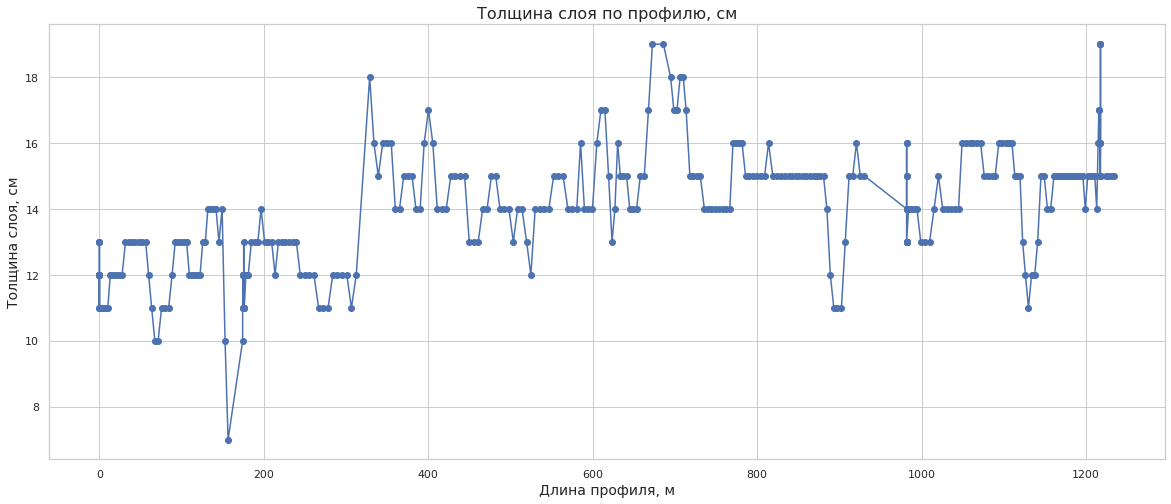

In [7]:
# введем несколько категорий в зависимости от толщины слоя. Здесь можно вводить свои диапазоны, лишние строки удалить 
def thickness_category(layer_thickness):
    if 5 <= layer_thickness <= 10:
        return 'толщина 5-10 см'
    if 10 < layer_thickness <= 15:
        return 'толщина 11-15 см'
    if 15 < layer_thickness <= 20:
        return 'толщина 16-20 см'
    else:
        return 'толщина более 20 см'
layer_thickness['thickness_category'] = layer_thickness['layer_thickness'].apply(thickness_category)

# объединяем таблицы с толщиной слоя и координатами
final_data = layer_thickness.merge(gps_track, on='frame_number')

final_data1 = final_data[['frame_number', 'longitude_diff_sum','latitude_diff_sum', 'layer_thickness','thickness_category',
                          'distance']]
final_data = final_data[['frame_number', 'latitude','longitude', 'layer_thickness', 'thickness_category', 'distance']]

print('Первые 5 строк итоговой таблицы толщины слоя по профилю:')
display(final_data.head(5))
print('Последние 5 строк итоговой таблицы толщины слоя по профилю:')
display(final_data.tail(5))
print('Всего точек измерений толщины слоя по профилю:', len(final_data))

f, ax = plt.subplots(figsize = (20,8))
plt.plot(final_data.distance, final_data.layer_thickness, marker="o")
plt.title("Толщина слоя по профилю, см", fontsize = 16) 
plt.xlabel("Длина профиля, м", fontsize = 14) 
plt.ylabel("Толщина слоя, см", fontsize = 14) 
#plt.xlim(0, 100) # если нужно настроить диапазон по оси y, введите нужные значения
#plt.ylim(0, 30) # если нужно настроить диапазон по оси y, введите нужные значения
plt.show()

In [8]:
# если видим на графике слишком тонкий или толстый слой в каком-то месте и нужно узнать там толщину и локализовать место
# нужно вбить в условие ниже граничную толщину и будут выведены нужные толщины и расстояния на профиле
display(final_data.query('layer_thickness < 10'))

,frame_number,latitude,longitude,layer_thickness,thickness_category,distance
59,1498,55.771882,37.517767,7,толщина 5-10 см,156.5


#### Выводы

- ввели несколько категорий в зависимости от толщины слоя: толщина 5-10 см, толщина 11-15 см, толщина 16-20 см, толщина более 20 см
- объединили таблицы с толщиной слоя и координатами, получили таблицу final_fata, вывели первые и последние 5 строк
- построили важный график толщины слоя по профилю. На нем показан весь профиль записи толщины слоя от расстояния. Меняя параметры xlim и ylim можно посмотреть любой участок и любой диапазон толщин слоя
- при необходимости можно локализовать место и вывести нужные строки таблицы, указав условие по толщине

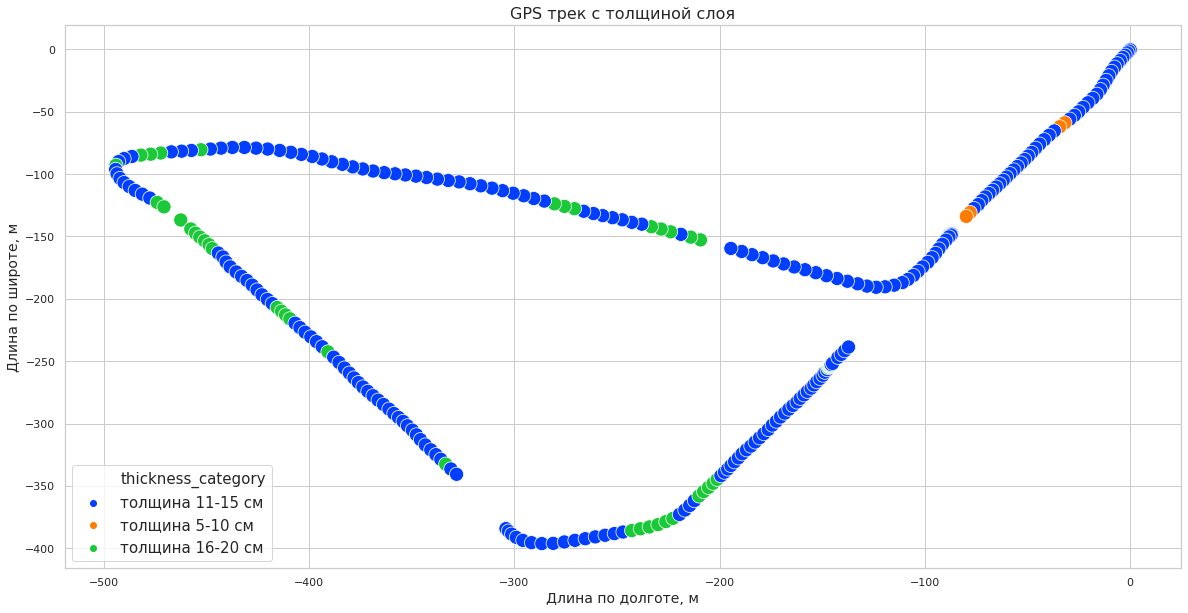

In [9]:
# построим график GPS трека с наложением информации о категории толщины слоя
# пропуски в треке - места остановок и удаленных "пустых" измерений

f, ax = plt.subplots(figsize = (20,10))
sns.scatterplot(x = "longitude_diff_sum", y = "latitude_diff_sum", data = final_data1, hue = "thickness_category", 
                palette="bright", s=200)
plt.title("GPS трек с толщиной слоя", fontsize = 16) 
plt.xlabel("Длина по долготе, м", fontsize = 14)
plt.ylabel("Длина по широте, м", fontsize = 14)
#plt.xlim(-40, -30) # если нужно настроить диапазон по оси y, введите нужные значения
#plt.ylim(-800, -600) # если нужно настроить диапазон по оси y, введите нужные значения
plt.legend(loc = 3, prop={'size': 15}) # если данное окошко мешает выводу графика, можно его передвинуть (loc от 1 до 4)
plt.show()

In [14]:
# построим интерактивный график GPS трека, значения толщины слоя и расстояния можно просматривать, перемещая курсор мыши

chart1 = alt.Chart(final_data1).mark_circle(size=80).encode(
    x='longitude_diff_sum',
    y='latitude_diff_sum',
    color=alt.Color('thickness_category', scale=alt.Scale(scheme='category10')),
    tooltip=[alt.Tooltip('layer_thickness', title='Толщина слоя'), alt.Tooltip('distance', title='Расстояние от точки старта')]
).interactive().properties(
    width=1000,
    height=500,
    title='Интерактивный график GPS трека со значениями толщины слоя и расстояния в каждой точке'
)

chart1.save('chart1.html') # сохраним этот график в интерактивном html-файле chart1
chart1

alt.Chart(...)

In [15]:
# создаем таблицу с географическими координатами с помощью библиотеки geopandas
import geopandas
gdf = geopandas.GeoDataFrame(
    final_data, geometry=geopandas.points_from_xy(final_data.longitude, final_data.latitude))
gdf.crs = {'init': 'epsg:4326'}
display(gdf.head())

,frame_number,latitude,longitude,layer_thickness,thickness_category,distance,geometry
0,17,55.773087,37.518773,12,толщина 11-15 см,0.0,POINT (37.51877 55.77309)
1,39,55.773087,37.518773,12,толщина 11-15 см,0.0,POINT (37.51877 55.77309)
2,70,55.773087,37.518773,12,толщина 11-15 см,0.0,POINT (37.51877 55.77309)
3,87,55.773087,37.518773,12,толщина 11-15 см,0.0,POINT (37.51877 55.77309)
4,106,55.773087,37.518773,12,толщина 11-15 см,0.0,POINT (37.51877 55.77309)


In [20]:
# построим интерактивный график GPS трека на картах Openstreetmaps, значения толщины слоя и расстояния можно просматривать, наводя курсор мыши

data = final_data[['latitude', 'longitude']].values.tolist()
map1 = folium.Map(location=data[-1], zoom_start=16)
folium.Circle(radius=10, location=data[0], popup='Start', color='green', fill=True,).add_to(map1) # Круглый маркер зеленого цвета показывает начальную точку
folium.Circle(radius=10, location=data[-1], popup='End', color='red', fill=True,).add_to(map1) # Круглый маркер красного цвета показывает конечную точку

#folium.Marker(location=data[0], popup = "Start", icon=folium.Icon(color = 'green')).add_to(map1)
#folium.Marker(location=data[-1], popup = "End", icon=folium.Icon(color = 'red')).add_to(map1)
#HeatMap(data=data, radius=10, max_zoom=22, blur=10, max_val=15).add_to(map1)

folium.GeoJson(
    gdf,
    name='final_data',
    style_function=None,
    tooltip=folium.GeoJsonTooltip(
        fields=['layer_thickness', 'distance'],
        aliases=['Layer thickness','Distance from start point'], 
        localize=False
        ),
    smooth_factor = 0
).add_to(map1)

map1.save("map1.html") # сохраним этот график в интерактивном html-файле map1
map1

#### Выводы
- построили график GPS-трека с толщиной слоя
- построили интерактивный график GPS трека со значениями толщины слоя и расстояния
- построили интерактивный график на карте Openstreetmaps GPS трека со значениями толщины слоя и расстояния

In [23]:
# объединим все таблицы (с границами, координатами и метками в одну)

layer_thickness_labels_d = layer_thickness.merge(labels_d, on='frame_number', how='left')
layer_thickness_labels_d = layer_thickness_labels_d.fillna('')

full_data = layer_thickness_labels_d.merge(gps_track, on='frame_number', how='left')
full_data = full_data.fillna(method='pad')
full_data = full_data.fillna(0)

full_data = full_data[['frame_number', 'label_number', 'layer_thickness','thickness_category', 'latitude','longitude', 
                        'longitude_diff_sum','latitude_diff_sum', 'distance']]

full_data_label = full_data.query('label_number != ""')
#full_data_label['label_number'] = full_data_label['label_number'].astype(int)

layer_thickness_labels = layer_thickness.merge(labels, on='frame_number', how='left')
layer_thickness_labels = layer_thickness_labels.fillna('')

full_data_d = layer_thickness_labels.merge(gps_track, on='frame_number', how='left')
full_data_d = full_data_d.fillna(method='pad')
full_data_d = full_data_d.fillna(0)

full_data_d = full_data_d[['frame_number', 'label_number', 'layer_thickness','thickness_category', 'latitude','longitude', 
                        'longitude_diff_sum','latitude_diff_sum', 'distance']]

full_data_label_d = full_data_d.query('label_number != ""')

print('Итоговая таблица со всеми данными для слоя (последние 5 строк):')
display(full_data.tail())

#display(full_data.loc[2970:2990]) # чтобы вывести диапазон строк таблицы (задаваемый в [])
#full_data.loc[16,'label_number'] = 1 # чтобы задать вручную любое значение ячейки

print('Итоговая таблица с данными меток для слоя:')
display(full_data_label)

Итоговая таблица со всеми данными для слоя (последние 5 строк):


,frame_number,label_number,layer_thickness,thickness_category,latitude,longitude,longitude_diff_sum,latitude_diff_sum,distance
8350,9996,,13,толщина 11-15 см,55.770938,37.517045,-137.22,-238.61,1234.0
8351,9997,,13,толщина 11-15 см,55.770938,37.517045,-137.22,-238.61,1234.0
8352,9998,,13,толщина 11-15 см,55.770938,37.517045,-137.22,-238.61,1234.0
8353,9999,,13,толщина 11-15 см,55.770938,37.517045,-137.22,-238.61,1234.0
8354,10000,,13,толщина 11-15 см,55.770938,37.517045,-137.22,-238.61,1234.0


Итоговая таблица с данными меток для слоя:


,frame_number,label_number,layer_thickness,thickness_category,latitude,longitude,longitude_diff_sum,latitude_diff_sum,distance
2624,3461,1,11,толщина 11-15 см,55.771628,37.516388,-189.25,-161.99,306.5
4235,5119,2,14,толщина 11-15 см,55.772220,37.512545,-494.23,-96.21,633.6
6235,7881,1d,13,толщина 11-15 см,55.769628,37.514942,-304.10,-384.17,981.8
6927,8573,2d,16,толщина 16-20 см,55.769830,37.516098,-212.33,-361.75,1089.5


#### Выводы

- получили таблицу full_data, где собрана вся информация по толщинам слоев, координатам и меткам
- получили таблицу full_data_label, где выведена вся информация full_data по меткам

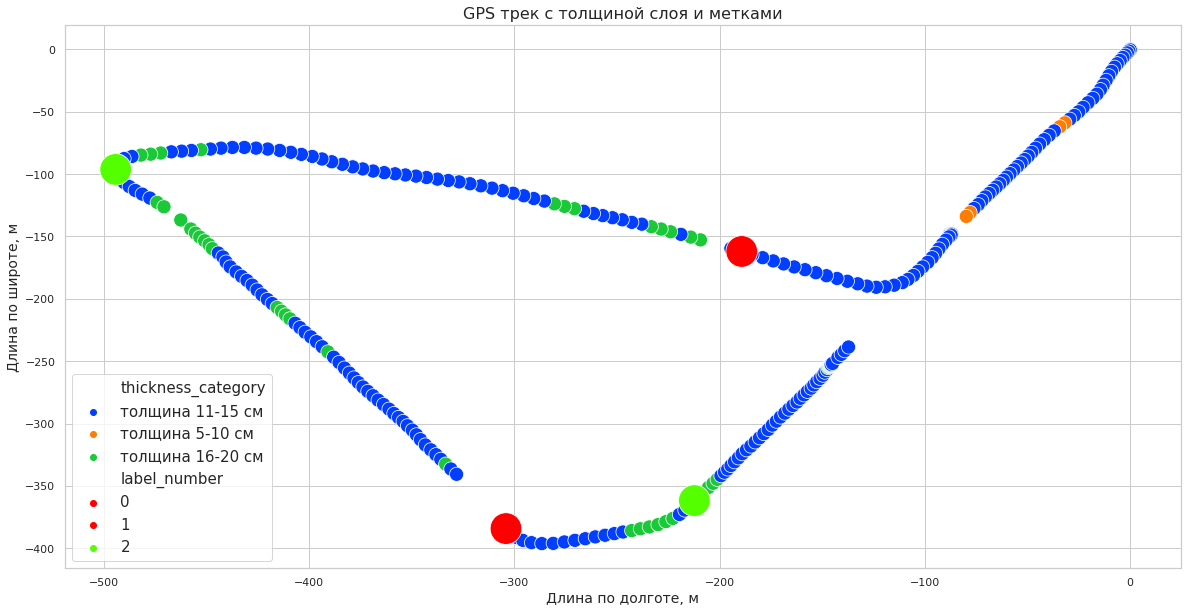

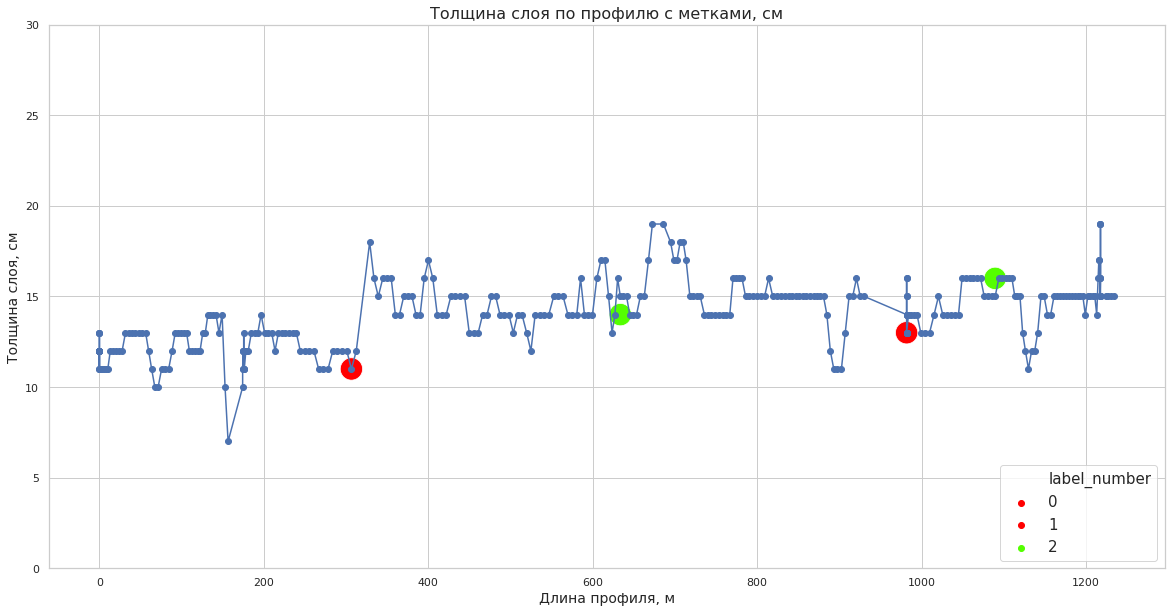

In [24]:
# построим график GPS трека с толщиной слоя и метками
# на графике сначала указаны номера "красных" меток, установленных в режиме измерений, 
# потом номера "синих" меток, установленных в режиме обработки
f, ax = plt.subplots(figsize = (20,10))
sns.scatterplot(x = "longitude_diff_sum", y = "latitude_diff_sum", data = final_data1, hue = "thickness_category", 
                palette="bright", s=200)
sns.scatterplot(x = "longitude_diff_sum", y = "latitude_diff_sum", data = full_data_label_d, hue = "label_number", 
                palette="prism", s=1000) 
plt.title("GPS трек с толщиной слоя и метками", fontsize = 16) 
plt.xlabel("Длина по долготе, м", fontsize = 14)
plt.ylabel("Длина по широте, м", fontsize = 14)
#plt.xlim(-200, -100) # если нужно настроить диапазон по оси y, введите нужные значения
#plt.ylim(-250, -600) # если нужно настроить диапазон по оси y, введите нужные значения
plt.legend(loc = 3, prop={'size': 15})
plt.show()

# построим график толщины слоя по профилю с метками
# на графике сначала указаны номера "красных" меток, установленных в режиме измерений, 
# потом номера "синих" меток, установленных в режиме обработки
f, ax = plt.subplots(figsize = (20,10))
plt.plot(final_data.distance, final_data.layer_thickness, marker="o")
sns.scatterplot(x = "distance", y = "layer_thickness", data = full_data_label_d, hue = "label_number",palette="prism", s=500)
plt.title("Толщина слоя по профилю с метками, см", fontsize = 16) 
plt.xlabel("Длина профиля, м", fontsize = 14) 
plt.ylabel("Толщина слоя, см", fontsize = 14) 
plt.ylim(0, 30) # если нужно настроить диапазон по оси y, введите нужные значения
plt.legend(loc = 4, prop={'size': 15})
plt.show()

In [25]:
chart1 = alt.Chart(final_data1).mark_circle(size=60).encode(
    x='longitude_diff_sum',
    y='latitude_diff_sum',
    color=alt.Color('thickness_category', scale=alt.Scale(scheme='category10')),
    tooltip=[alt.Tooltip('layer_thickness', title='Толщина слоя'), alt.Tooltip('distance', title='Расстояние от точки старта')]
).interactive().properties(width=1000, height=500)

chart12 = alt.Chart(full_data_label).mark_circle(size=500).encode(
    x='longitude_diff_sum',
    y='latitude_diff_sum',
    color=alt.Color('label_number:O', scale=alt.Scale(scheme='set1')),
    tooltip=[alt.Tooltip('layer_thickness', title='Толщина слоя'), alt.Tooltip('distance', title='Расстояние от точки старта')]
).interactive().properties(width=1000, height=500, title='Интерактивный график GPS трека и меток со значениями толщины слоя и расстояния в каждой точке')

chart2 = chart1 + chart12
chart2.save('chart2.html')
chart2

alt.LayerChart(...)

#### Выводы

- построили важные графики "GPS трек с толщиной слоя и метками" и "Толщина слоя по профилю с метками". Категории толщины и номера меток указаны в легенде графика
- построили интерактивный график GPS трека и меток со значениями толщины слоя и расстояния в каждой точке

In [0]:
# выгружаем таблицы в файл excel 
final_data.to_excel("final_data.xlsx")
full_data.to_excel("full_data.xlsx")
full_data_label.to_excel("full_data_label.xlsx")

In [0]:
# при ошибке выгрузки в файл excel уберите решетку перед pip, установите openpyxl и повторите выгрузку
#pip install openpyxl

Для составления отчета можно использовать выгруженные итоговые таблицы final_data.xlsx, full_data.xlsx, full_data_label.xlsx, картинки графиков "GPS трек с толщиной слоя и метками", "Толщина слоя по профилю с метками", "Толщина слоя по профилю", "GPS трек", "Толщина слоя", "График частоты значений толщин слоя", значения толщин слоя в метках и другие данные.

Интерактивные графики GPS трека, GPS трека и меток, GPS трека на картах Openstreetmaps со значениями толщины слоя и расстояния в каждой точке можно использовать как при составлении отчета, так и для просмотра в браузере в виде html-файлов 